# Regridding climate data with xESMF

A common element of climate data workflows is regridding, or reprojection, of model data unto more standard grids, or simply unto another dataset's grid. The powerful [ESMF](http://earthsystemmodeling.org/docs/release/ESMF_8_0_1/ESMF_usrdoc/) program, written in FORTRAN, has long been a reference in the matter. The [xESMF](https://pangeo-xesmf.readthedocs.io/en/latest/) python package provides an easy to use high-level API for using ESMF's methods. This notebook shows some examples of common regridding operations.

Regridding with `xESMF` is usually a two step process: 

 1. Create a `Regridder` objects from two datasets, defining the input and the output grids. This compute a weights mask which can, if needed, be saved to a netCDCF file.
 2. Regrid a DataArray or Dataset by calling the `Regridder` with it. As the weights have already been computed, it reuses them for all time slices, which allows much better performance than, for example, interpolation using `scipy.interpolation.interpn`.

In [1]:
# NBVAL_IGNORE_OUTPUT

import warnings

# ipykernel_launcher.py:1: DeprecationWarning: xclim.subset is deprecated in xclim v0.19.1-beta. Please take note that xclim presently exposes the 'clisops' library subsetting API via `from clisops.core import subset`.
warnings.filterwarnings("ignore", category=DeprecationWarning)

from xclim.subset import subset_bbox  # For subsetting
from xclim.testing import open_dataset  # For opening xclim's test data
import cf_xarray as cfxr
import xarray as xr
import xesmf as xe

# Other utilities for style and clean examples
import copy
import matplotlib.pyplot as plt

#  A colormap with grey where the data is missing
cmap = copy.copy(plt.cm.get_cmap('viridis'))
cmap.set_bad('lightgray')

2021-04-08 17:48:26,384 - matplotlib.font_manager - INFO - Generating new fontManager, this may take some time...


## Simple example : Bilinear regridding from model to obs

Our input in this example is a year of monthly sea ice concentration data from a CanESM5 run for CMIP6. It lies on an irregular grid defined by `latitude` and `longitude` coordinates. We'll interpolate the sea ice concentration to a regular observational grid from Natural Resources Canada. 

### The input data

In [2]:
# NBVAL_IGNORE_OUTPUT

# The input test data is hosted on the Ouranos THREDDS
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/testdata/xclim/cmip6/sic_SImon_CCCma-CanESM5_ssp245_r13i1p2f1_2020.nc"
ds_in = xr.open_dataset(url)
ds_in

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, time: 12, vertices: 4)
Coordinates:
  * time                (time) object 2020-01-16 12:00:00 ... 2020-12-16 12:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    type                |S64 ...
    latitude            (j, i) float64 ...
    longitude           (j, i) float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object ...
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
    siconc              (time, j, i) float32 ...
    areacello           (j, i) float32 ...
Attributes:
    CCCma_model_hash:                fc4bb7db954c862d023b546e19aec6c588bc0552
    CCCma_parent_runid:              p2-his13
    CCCma_pycmor_hash:               26c970628162d607fffd14254956ebc6dd3b6f49
    CCCma_runid:                     p2-s4513
    Conventions:                     CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:       2015:01:01:00
    YMDH_branch_time_in_parent:      2015:01:01:00
    activity_id:                     ScenarioMIP
    branch_method:                   Spin-up documentation
    branch_time_in_child:            60225.0
    branch_time_in_parent:           60225.0
    contact:                         ec.cccma.info-info.ccmac.ec@canada.ca
    creation_date:                   2019-09-25T23:01:33Z
    data_specs_version:              01.00.30
    experiment:                      update of RCP4.5 based on SSP2
    experiment_id:                   ssp245
    external_variables:              areacello
    forcing_index:                   1
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.CCC...
    grid:                            ORCA1 tripolar grid, 1 deg with refineme...
    grid_label:                      gn
    history:                         2019-09-25T23:01:33Z ;rewrote data to be...
    initialization_index:            1
    institution:                     Canadian Centre for Climate Modelling an...
    institution_id:                  CCCma
    mip_era:                         CMIP6
    nominal_resolution:              100 km
    parent_activity_id:              CMIP
    parent_experiment_id:            historical
    parent_mip_era:                  CMIP6
    parent_source_id:                CanESM5
    parent_time_units:               days since 1850-01-01 0:0:0.0
    parent_variant_label:            r13i1p2f1
    physics_index:                   2
    product:                         model-output
    realization_index:               13
    realm:                           seaIce
    references:                      Geophysical Model Development Special is...
    source:                          CanESM5 (2019): \naerosol: interactive\n...
    source_id:                       CanESM5
    source_type:                     AOGCM
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        SImon
    table_info:                      Creation Date:(09 May 2019) MD5:38ea1fbd...
    title:                           CanESM5 output prepared for CMIP6
    variable_id:                     siconc
    variant_label:                   r13i1p2f1
    version:                         v20190429
    license:                         CMIP6 model data produced by The Governm...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/9e4f804b-c161-44fa-acd1-c2e...
    DODS.strlen:                     64
    DODS.dimName:                    maxStrlen64
    DODS_EXTRA.Unlimited_Dimension:  time

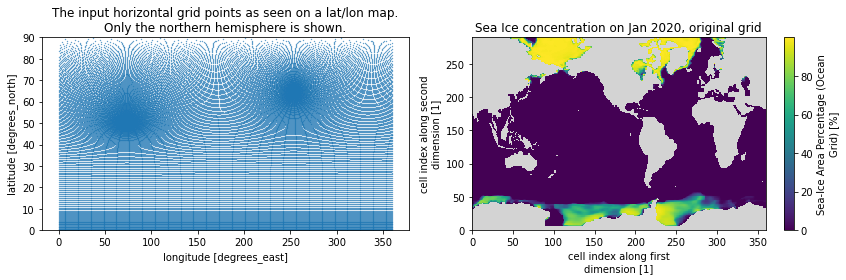

In [3]:
# Let's look at the grid shape itself and the data for one time step
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ds_in.plot.scatter(x='longitude', y='latitude', s=0.1, ax=axs[0])
axs[0].set_title('The input horizontal grid points as seen on a lat/lon map.\nOnly the northern hemisphere is shown.')
axs[0].set_ylim(0, 90)

ds_in.siconc.isel(time=0).plot(ax=axs[1], cmap=cmap)
axs[1].set_title('Sea Ice concentration on Jan 2020, original grid')
fig.tight_layout()

### The output grid

The NRCAN observations' dataset uses a simple rectangular lat/lon grid over Canada at about 10km resolution. To reduce computation time for this example, we'll first crop the grid to include only Hudson Bay and the Labrador Sea.

In [4]:
# NBVAL_IGNORE_OUTPUT

url_obs = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily_v2/nrcan_canada_daily_V2-allvars-agg.ncml"

# For this example, we're not interested in the observation data, only its underlying grid, so we'll select a single time step. 
ds_obs = xr.open_dataset(url_obs).sel(time='1993-05-20')

# Subset over the Hudson Bay and the Labrador Sea for the example
bbox = dict(lon_bnds=[-99.5, -41.92], lat_bnds=[50.35, 67.61])
ds_tgt = subset_bbox(ds_obs, **bbox)
ds_tgt

<xarray.Dataset>
Dimensions:  (lat: 207, lon: 570)
Coordinates:
  * lat      (lat) float32 67.54 67.46 67.38 67.29 ... 50.62 50.54 50.46 50.38
  * lon      (lon) float32 -99.46 -99.38 -99.29 -99.21 ... -52.21 -52.13 -52.04
    time     datetime64[ns] 1993-05-20
Data variables:
    tasmin   (lat, lon) float32 ...
    tasmax   (lat, lon) float32 ...
    pr       (lat, lon) float32 ...
Attributes:
    Conventions:     CF-1.5
    title:           NRCAN 10km Gridded Climate Dataset
    history:         Fri Jan 25 14:11:15 2019 : Convert from original format ...
    institution:     NRCAN
    source:          ANUSPLIN
    redistribution:  Data not public. Partners wishing to use this data must ...
    institute_id:    NRCAN
    frequency:       day
    project_id:      GriddedObs
    model_id:        ANUSPLIN
    references:      website: http://cfs.nrcan.gc.ca/projects/3/6

Text(0.5, 1.0, 'Target regular grid')

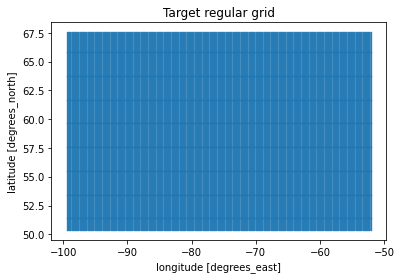

In [5]:
ds_tgt.cf.plot.scatter(x='longitude', y='latitude', s=0.1)
plt.title('Target regular grid')

xESMF relies on the useful [cf_xarray](https://cf-xarray.readthedocs.io/en/latest/) package to infer which variables are the latitude and longitude points. It will automatically know to use `longitude` and `latitude` on the datasets because their attributes are correctly set, as `ds.cf.describe()`  shows:

In [6]:
# NBVAL_IGNORE_OUTPUT

ds_in.cf.describe()

Coordinates:
- CF Axes: * T: ['time']
             X, Y, Z: n/a

- CF Coordinates:   longitude: ['longitude']
                    latitude: ['latitude']
                  * time: ['time']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   area_type: ['type']
                    latitude: ['latitude']
                    longitude: ['longitude']
                  * time: ['time']

Data Variables:
- Cell Measures:   area: ['areacello']
                   volume: n/a

- Standard Names:   cell_area: ['areacello']
                    sea_ice_area_fraction: ['siconc']



If those attributes were **not** set, we would need to rename the coordinates to `lon` and `lat`, xESMF's default's coordinate names.

### Regridding input data unto the output grid

First we create the regridding object, using the "bilinear" method, and then simply call it with the array that we want regridded (here `siconc`).

In [7]:
reg_bil = xe.Regridder(ds_in, ds_tgt, 'bilinear')
reg_bil  # Show information about the regridding

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_291x360_207x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (291, 360) 
Output grid shape:          (207, 570) 
Periodic in longitude?      False

Text(0.5, 1.0, 'Regridded sic data (Jan 2020)')

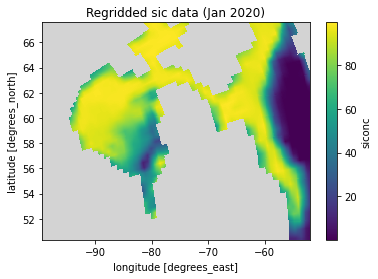

In [8]:
# xesmf/frontend.py:476: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
warnings.filterwarnings("ignore", category=FutureWarning)

# Apply the regridding weights to the input sea ice concentration data
sic_bil = reg_bil(ds_in.siconc)

# Plot the results
sic_bil.isel(time=0).plot(cmap=cmap)
plt.title('Regridded sic data (Jan 2020)')

The output now has the same grid as the target! The regridding operation was broadcasted along the non spatial dimensions (here `time`), so that all time steps were regridded using the same pre-computed weights.

## Second example : Conservative regridding and reusing weights

xESMF provides the following regridding methods : "bilinear", "conservative", "conservative_normed", "nearest_s2d", "nearest_d2s" and "patch" (see [method descriptions](https://earthsystemmodeling.org/regrid/#regridding-methods)). Conservative methods preserve areal averages, and for these methods we need to provide the coordinates of the grid cells' corners rather than the coordinates at the cells center.

### Untangling corners definitions

Before we go further, it's worth highlighting differences between xESMF's description of corner coordinates and how the same information is stored in CF-compliant files. 

For an `N x M` lon/lat grid,  xESMF expects an array with one element more than the coordinates. For example, on a regular grid, the corner of point at `lon[0]` are given by `lon_b[0]` and `lon_b[1]`. However, in a typical CF-compliant file, *grid corner* information is in an array of shape (N, 2) typically called `lon_bounds` and `lat_bounds`. Thus, the western and eastern corners of point at `lon[0]` are given by `lon_corners[0, 0]` and `lon_corners[0, 1]`. 

The `cf_xarray` package differentiates the two concepts by naming the CF-compliant one "bounds" and the xESMF one "vertices". However, CF conventions sometime uses vertices and bound interchangeably, and in our model dataset, the `vertices_longitude` variable stores corners according to the "bounds" definition...  We will nevetheless stick with `cf_xarray`'s nomenclature in the following.

The table below summarizes the difference between the two versions:

|                        | bounds    | vertices   |
|------------------------|-------------|--------------|
| CF-compliant           | Yes         | No           |
| Shape (regular grid)   | (N, 2)      | (N+1,)       |
| Shape (irregular grid) | (Nx, Ny, 4) | (Nx+1, Ny+1) |


### Computing the corners

The corners of regular grids (1D lat/lon) are infered automatically if not given. This will be the case for our `ds_tgt` dataset.

For irregular grids, `xESMF` will check for variables `lon_b` and `lat_b`, or try automatic detection with the help of `cf_xarray`. If they are found, it uses `cf_xarray`'s method to convert from the CF-compliant "bounds" to the required "vertices" syntax. However, a small bug in xESMF 0.5.2 prevents use from using this feature with our model dataset. We will convert the corner variables ourselves from the CF-compliant format we have to the format xESMF expects.

In [9]:
# Get the bounds variable and convert them to "vertices" format
# Order=none, means that we do not know if the bounds are listed clockwise or counterclockwise, so we ask cf_xarray to try both.
lat_corners = cfxr.bounds_to_vertices(ds_in.vertices_latitude, 'vertices', order=None)
lon_corners = cfxr.bounds_to_vertices(ds_in.vertices_longitude, 'vertices', order=None)
ds_in_crns = ds_in.assign(lon_b=lon_corners, lat_b=lat_corners)

### Regridding

The regridding process is as simple as above now that `ds_in_crns` contains the corner coordinates (`lon_b`, `lat_b`). Here we also pass a filename, so that the weights are saved to disk and can be reused (see below).

In [10]:
%%time
reg_cons = xe.Regridder(ds_in_crns, ds_tgt, 'conservative', filename='conservative_regridder.nc')
print(reg_cons)

# Regrid as before
sic_cons = reg_cons(ds_in_crns.siconc)

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_regridder.nc 
Reuse pre-computed weights? False 
Input grid shape:           (291, 360) 
Output grid shape:          (207, 570) 
Periodic in longitude?      False
CPU times: user 4.13 s, sys: 36.3 ms, total: 4.16 s
Wall time: 4.16 s


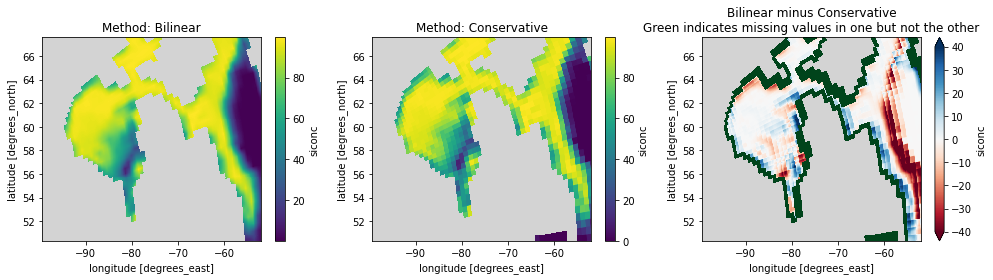

In [11]:
# Now let's look at the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

sic_bil.isel(time=0).plot(ax=axs[0], cmap=cmap)
axs[0].set_title('Method: Bilinear')

sic_cons.isel(time=0).plot(ax=axs[1], cmap=cmap)
axs[1].set_title('Method: Conservative')

# A divergent colormap with gray on missing values
cmap_div = copy.copy(plt.cm.get_cmap('RdBu'))
cmap_div.set_bad('lightgray')
(sic_bil - sic_cons).isel(time=0).plot(ax=axs[2], cmap=cmap_div, vmin=-40, vmax=40)
diff_NaNs = (sic_bil.isnull() ^ sic_cons.isnull()).isel(time=0)
diff_NaNs.where(diff_NaNs).plot(cmap=plt.cm.Greens, ax=axs[2], vmin=0, add_colorbar=False)
axs[2].set_title('Bilinear minus Conservative\nGreen indicates missing values in one but not the other')
fig.tight_layout()

As we can see, "bilinear" regridding results in a smooth output field, while "conservative" results preserves the original data's coarser resolution. In the last panel, the green cells show that the two methods have different missing values results. In our case of increasing resolution, there will often be more missing values when using "bilinear". The next example explains how xESMF can explictely manage missing values. But before, we look at the reusability of the weights generated by xESMF.

### Reusing weights

The weights of the previous regridding have been written to disk. We can simply reuse them by specifying that filename and passing `reuse_weights=True`. You'll notice how faster the process is, as we don't compute the weights again.

In [12]:
%%time
reg_bis = xe.Regridder(ds_in_crns, ds_tgt, 'conservative', reuse_weights=True, filename='conservative_regridder.nc')
print(reg_bis)

# Regrid as before
sic_bis = reg_bis(ds_in_crns.siconc)

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_regridder.nc 
Reuse pre-computed weights? True 
Input grid shape:           (291, 360) 
Output grid shape:          (207, 570) 
Periodic in longitude?      False
CPU times: user 75.6 ms, sys: 3.94 ms, total: 79.5 ms
Wall time: 77.7 ms


## Third example : Regridding and masks

By defaut, xESMF doesn't handle missing values in a special way, so when they are present in the input data they often bleed into the regridded field, especially when decreasing resolution. This example demonstrates this bleeding effect and how it can be mitigated using masks.

We will use a global model dataset and try to regrid the NRCAN observation unto the global grid, thus decreasing the resolution.


### Target grid and mask

The target grid will be the CanESM2 model grid, but with the ocean masked. In the following, we fetch both the "tasmin" data for the same date as the obs and the "sftlf" mask so we can obtain a land mask (land fraction above 0.25).

In [13]:
# NBVAL_IGNORE_OUTPUT

# Model data for tasmin
ds_tgt = xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/cccma/CanESM2/historical/day/atmos/r1i1p1/tasmin/tasmin_day_CanESM2_historical_r1i1p1_18500101-20051231.nc')
# Land-sea fraction
ds_sftlf = xr.open_dataset('https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/cccma/CanESM2/historical/fx/atmos/r0i0p0/sftlf/sftlf_fx_CanESM2_historical_r0i0p0.nc')
ds_tgt = ds_tgt.sel(time='1993-05-20')  # Extract same day as obs
ds_tgt = ds_tgt.rename(bnds='bounds')  # Small fix for xESMF 0.5.2
ds_tgt['tasmin'] = ds_tgt.tasmin.where(ds_sftlf.sftlf > 0.25)  # Mask tasmin data that is over the ocean
ds_tgt

<xarray.Dataset>
Dimensions:    (bounds: 2, lat: 64, lon: 128, time: 1)
Coordinates:
  * time       (time) object 1993-05-20 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bounds
Data variables:
    time_bnds  (time, bounds) object ...
    lat_bnds   (lat, bounds) float64 ...
    lon_bnds   (lon, bounds) float64 ...
    tasmin     (time, lat, lon) float32 208.3 207.9 207.4 206.8 ... nan nan nan
Attributes:
    institution:                     CCCma (Canadian Centre for Climate Model...
    institute_id:                    CCCma
    experiment_id:                   historical
    source:                          CanESM2 2010 atmosphere: CanAM4 (AGCM15i...
    model_id:                        CanESM2
    forcing:                         GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes C...
    parent_experiment_id:            piControl
    parent_experiment_rip:           r1i1p1
    branch_time:                     171915.0
    contact:                         cccma_info@ec.gc.ca
    references:                      http://www.cccma.ec.gc.ca/models
    initialization_method:           1
    physics_version:                 1
    tracking_id:                     41050cdf-8acf-4227-a192-3264026d45de
    branch_time_YMDH:                2321:01:01:00
    CCCma_runid:                     IGM
    CCCma_parent_runid:              IGA
    CCCma_data_licence:              1) GRANT OF LICENCE - The Government of ...
    product:                         output
    experiment:                      historical
    frequency:                       day
    creation_date:                   2011-04-14T00:23:54Z
    history:                         2011-04-14T00:23:54Z CMOR rewrote data t...
    Conventions:                     CF-1.4
    project_id:                      CMIP5
    table_id:                        Table day (28 March 2011) f9d6cfec5981bb...
    title:                           CanESM2 model output prepared for CMIP5 ...
    parent_experiment:               pre-industrial control
    modeling_realm:                  atmos
    realization:                     1
    cmor_version:                    2.5.4
    DODS_EXTRA.Unlimited_Dimension:  time

In [14]:
# NBVAL_IGNORE_OUTPUT

# Input grid and data : reuse ds_obs (NRCAN but without the subsetting)
ds_in = ds_obs[["tasmin"]]
ds_in

<xarray.Dataset>
Dimensions:  (lat: 510, lon: 1068)
Coordinates:
  * lat      (lat) float32 83.46 83.38 83.29 83.21 ... 41.29 41.21 41.12 41.04
  * lon      (lon) float32 -141.0 -140.9 -140.8 -140.7 ... -52.21 -52.13 -52.04
    time     datetime64[ns] 1993-05-20
Data variables:
    tasmin   (lat, lon) float32 ...
Attributes:
    Conventions:     CF-1.5
    title:           NRCAN 10km Gridded Climate Dataset
    history:         Fri Jan 25 14:11:15 2019 : Convert from original format ...
    institution:     NRCAN
    source:          ANUSPLIN
    redistribution:  Data not public. Partners wishing to use this data must ...
    institute_id:    NRCAN
    frequency:       day
    project_id:      GriddedObs
    model_id:        ANUSPLIN
    references:      website: http://cfs.nrcan.gc.ca/projects/3/6

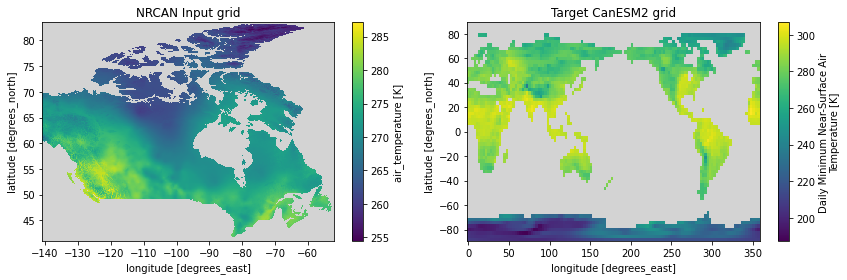

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ds_in.tasmin.plot(ax=axs[0], cmap=cmap)
axs[0].set_title('NRCAN Input grid')

ds_tgt.tasmin.plot(ax=axs[1], cmap=cmap)
axs[1].set_title('Target CanESM2 grid')
fig.tight_layout()

### Default regridding - No mask handling

We first naïvely try the regridding exactly as before. Here we use the "conservative_normed" method, the reason is explained at the end of the example.

In [16]:
reg_nomask = xe.Regridder(ds_in, ds_tgt, 'conservative_normed')
print(reg_nomask)
tasmin_nomask = reg_nomask(ds_in.tasmin)

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_510x1068_64x128.nc 
Reuse pre-computed weights? False 
Input grid shape:           (510, 1068) 
Output grid shape:          (64, 128) 
Periodic in longitude?      False


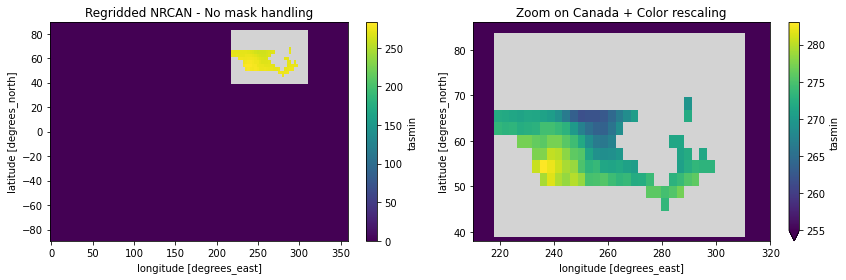

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

tasmin_nomask.plot(ax=axs[0], cmap=cmap)
axs[0].set_title('Regridded NRCAN - No mask handling')

tasmin_nomask.plot(ax=axs[1], cmap=cmap, vmin=255)
axs[1].set_xlim(210, 320)
axs[1].set_ylim(38, 86)
axs[1].set_title('Zoom on Canada + Color rescaling')
fig.tight_layout()

This ugly result is the default behaviour of xESMF when no mask information is passed :

1. A single missing value in the input suffices so that the target (coarser) grid cell is marked as missing. This erased all the Canadian Arctic Archipelago and most points near the sea in general.
2. Grid points outside the input grid are filled with 0s instead of NaNs. 

To resolve this, we pass as binary mask to xESMF. xESMF will then exclude the masked values from the computation, and this way the small islands in the Canadian Arctic Archipelago won't be hidden by missing values. It will also activate a mode where values outside the input grid are marked as missing (NaN), which is usually more useful.

Note that ESMF masks defined as `True` where data is valid, and `False` where it is missing. The variable must be named `mask` to get picked up by xESMF.

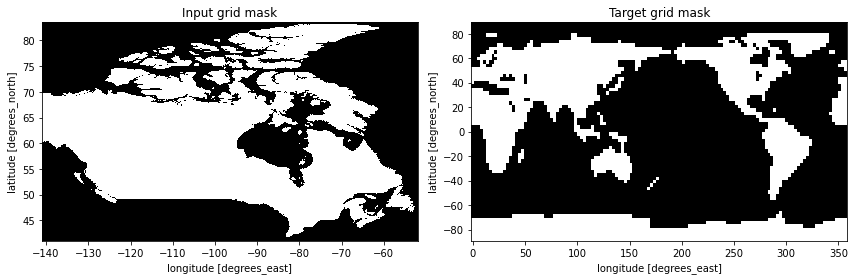

In [18]:
# Define the masks and assign them as variables for both the input and output datasets. 
in_mask = ds_in.tasmin.notnull()
ds_in_mask = ds_in.assign(mask=in_mask)

tgt_mask = ds_tgt.tasmin.isel(time=0).notnull()
ds_tgt_mask = ds_tgt.assign(mask=tgt_mask)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
in_mask.plot(ax=axs[0], cmap=plt.cm.binary_r, add_colorbar=False)
tgt_mask.plot(ax=axs[1], cmap=plt.cm.binary_r, add_colorbar=False)
axs[0].set_title('Input grid mask')
axs[1].set_title('Target grid mask')
fig.tight_layout()

In [19]:
reg_mask = xe.Regridder(ds_in_mask, ds_tgt_mask, 'conservative_normed')
reg_mask # Show information about the regriddingaa

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_510x1068_64x128.nc 
Reuse pre-computed weights? False 
Input grid shape:           (510, 1068) 
Output grid shape:          (64, 128) 
Periodic in longitude?      False

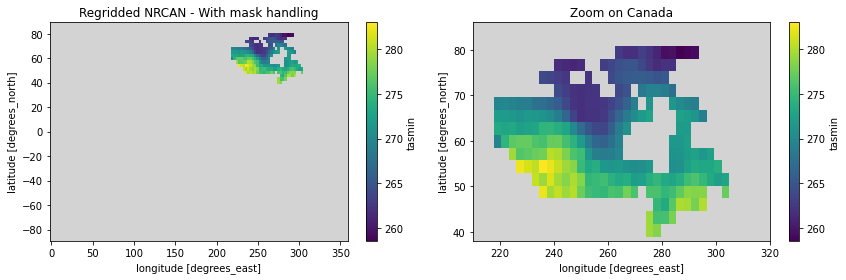

In [20]:
tasmin_mask = reg_mask(ds_in_mask.tasmin)
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

tasmin_mask.plot(ax=axs[0], cmap=cmap)
axs[0].set_title('Regridded NRCAN - With mask handling')

tasmin_mask.plot(ax=axs[1], cmap=cmap)
axs[1].set_xlim(210, 320)
axs[1].set_ylim(38, 86)
axs[1].set_title('Zoom on Canada')
fig.tight_layout()

Much better! As expected, grid cells near the sea are kept and points outside the input grid are marked as missing.

### Normalization for conservative regridding

The "conservative_normed" method includes information about the missing values in the final normalization of the data. On the other hand, the "conservative" method normalizes using the total area of the target cell, no matter how many input grid points were valid. The following figure shows how that can lead to large biases in the data near the boundaries. Indeed, in the example below, the temperatures reach values close to 0 Kelvins near the boundaries. 

Text(1.3, 0.3, 'Some values are close to 0 Kelvins.\nCanada can get cold, but not that cold!')

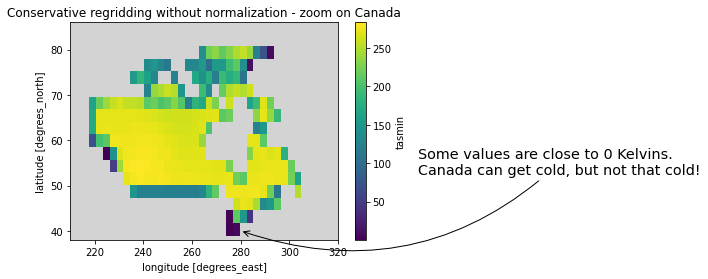

In [21]:
reg_mask_cons = xe.Regridder(ds_in_mask, ds_tgt_mask, 'conservative')
tasmin_mask_cons = reg_mask_cons(ds_in_mask.tasmin)

fig, ax = plt.subplots(figsize=(6, 4))
tasmin_mask_cons.plot(cmap=cmap, ax=ax)
ax.set_xlim(210, 320)
ax.set_ylim(38, 86)
ax.set_title('Conservative regridding without normalization - zoom on Canada')
ax.annotate("Some values are close to 0 Kelvins.\nCanada can get cold, but not that cold!", 
            (280, 40), xytext=(1.3, .3), xycoords="data", textcoords="axes fraction", fontsize="x-large",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-0.3"))

## Fourth example : Averaging over polygons

Because the conservative regridding method preserves areal averages, we can use xESMF to compute *exact* averages over polygons. We call it "exact" because is takes into account partial overlaps between the gridcells and the shapes, including potential holes. While it is fast and powerful, this polygon averaging functionality is new in xESMF and still lacks some features, like missing values handling and performance issues with high-resolution polygons.

The following example grabs some polygon shapes from PAVICS' Geoserver and averages the NRCAN data over them.

### Define polygon shapes

This example fetches all MRC of Québec and then only selects 10 large ones.

In [22]:
from owslib.wfs import WebFeatureService
import geopandas as gpd
import json

In [23]:
wfs_url = 'http://boreas.ouranos.ca/geoserver/wfs'
# Connect to GeoServer WFS service.
wfs = WebFeatureService(wfs_url, version='2.0.0')

# Get the json as a binary stream
# Here we select Quebec's MRCs polygons
# We select only a few properties
data = wfs.getfeature(
    typename='TravisTest:mrc_poly',
    #bbox=(-93.1, 41.1, -75.0, 49.6),
    outputFormat='json',
    propertyname=['the_geom', 'AREA', 'PERIMETER', 'MRS_NM_MRC']
)
# Load into a GeoDataFrame by reading the json on-the-fly
shapes_all = gpd.GeoDataFrame.from_features(json.load(data))
# Just for simplicity, let's take the 10 large MRCs
shapes = shapes_all.sort_values('AREA').iloc[18:28].drop(columns=['bbox']).set_index('MRS_NM_MRC')
shapes

,geometry,AREA,PERIMETER
MRS_NM_MRC,,,
Thérèse-De Blainville,"MULTIPOLYGON (((-73.91380 45.76660, -73.86020 ...",0.024553,1.130110
Les Moulins,"MULTIPOLYGON (((-73.80770 45.82160, -73.80040 ...",0.030774,1.174379
Laval,"MULTIPOLYGON (((-73.74490 45.66860, -73.74110 ...",0.030786,0.931105
L'Assomption,"MULTIPOLYGON (((-73.45670 45.94390, -73.45070 ...",0.033053,0.973447
Deux-Montagnes,"MULTIPOLYGON (((-73.89640 45.61690, -73.88050 ...",0.035064,1.217298
Longueuil,"MULTIPOLYGON (((-73.44470 45.65670, -73.41310 ...",0.035694,0.852245
Trois-Rivières,"MULTIPOLYGON (((-72.70510 46.42410, -72.70200 ...",0.039118,1.053528
L'Île-d'Orléans,"MULTIPOLYGON (((-70.81790 46.93420, -70.82970 ...",0.040729,1.061597
Sherbrooke,"MULTIPOLYGON (((-71.91990 45.52410, -71.91930 ...",0.042092,1.223525


### Validate and simplify shapes

High resolution polygons might slow down the creation of the xESMf averager object. Here we ensure polygons are simplified to a resolution 50x times finer than the input data. This should have a minimal impact on the output while still improving performance.

While it's not the case here, downloaded polygons sometime have topological problems which can be tested with `shapes.is_valid`. Simplifying polygons sometimes help overcome these issues.

In [24]:
shapes.is_valid.all()

True

In [25]:
# This is only to show the decrease in size
def count_points(elem):
    def _count(poly):
        return len(poly.exterior.coords) + sum(len(hole.coords) for hole in poly.interiors)
    if hasattr(elem, '__len__'):  # then it is a MultiPolygon
        return sum(_count(poly) for poly in elem)
    return _count(elem)

# Count the total number of nodes in the shapes:
print('Total number of nodes in the raw shapes : ', shapes.geometry.apply(count_points).sum())

min_grid_size = float(min(abs(ds_in.lat.diff('lat')).min(), abs(ds_in.lon.diff('lon')).min()))
print(f'Minimal grid size [°] of input ds: {min_grid_size:0.3f}, we will simplify to a tolerance of {min_grid_size / 100:0.5f}')

# Simplify geometries
shapes_simp = shapes.copy()
shapes_simp['geometry'] = shapes.simplify(min_grid_size / 100)

print('Total number of nodes in the simplified shapes : ', shapes_simp.geometry.apply(count_points).sum())
assert shapes_simp.buffer(0).is_valid.all()

Total number of nodes in the raw shapes :  1878
Minimal grid size [°] of input ds: 0.083, we will simplify to a tolerance of 0.00083
Total number of nodes in the simplified shapes :  707


### Averaging over each polygon

Performing the spatial average is as simple as regridding. We first construct a `SpatialAverager` object from the input grid and polygons, then call it with the data to average. Note that xESMf expects a list of shapes, so we pass the `shapes.geometry` series (and not the `GeoDataFrame` itself).

The returned DataArray was averaged along its spatial (lat/lon) dimensions and the average over the different shapes are along the new `geom` dimension, which is in the same order as the initial GeoDataframe.

In [26]:
# NBVAL_IGNORE_OUTPUT

savg = xe.SpatialAverager(ds_in, shapes_simp.geometry)
tn_avg = savg(ds_in.tasmin)
tn_avg

<xarray.DataArray 'tasmin' (geom: 10)>
array([281.28131884, 281.42250087, 281.75985849, 281.42762914,
       281.44295109, 282.08994858, 281.30878528, 282.45053599,
       282.17242125, 278.34574148])
Coordinates:
    time     datetime64[ns] 1993-05-20
    lon      (geom) float64 -73.83 -73.65 -73.73 -73.44 ... -70.92 -71.96 -75.66
    lat      (geom) float64 45.7 45.75 45.6 45.82 ... 46.36 46.94 45.4 45.49
Dimensions without coordinates: geom
Attributes:
    regrid_method:  conservative

### Merging polygon features' properties into the result

In the previous results, the polygons are indexed along the `geom` dimension, but we'd like to have the region names and properties. 

In [27]:
# NBVAL_IGNORE_OUTPUT

# Set coordinates of "geom" to the shapes index
tn_avg['geom'] = shapes_simp.index.values

# Get a Dataset of properties from the dataframe
# Drop the geometries (we don't want them), convert to xarray and rename the index so it matches the one in tn_avg
props = shapes_simp.drop(columns=['geometry']).to_xarray().rename(MRS_NM_MRC='geom')

# Assign all properties as "auxiliary" coordinates
tn_avg = tn_avg.assign_coords(**props.data_vars)
tn_avg

<xarray.DataArray 'tasmin' (geom: 10)>
array([281.28131884, 281.42250087, 281.75985849, 281.42762914,
       281.44295109, 282.08994858, 281.30878528, 282.45053599,
       282.17242125, 278.34574148])
Coordinates:
    time       datetime64[ns] 1993-05-20
    lon        (geom) float64 -73.83 -73.65 -73.73 ... -70.92 -71.96 -75.66
    lat        (geom) float64 45.7 45.75 45.6 45.82 ... 46.36 46.94 45.4 45.49
  * geom       (geom) object 'Thérèse-De Blainville' ... 'Gatineau'
    AREA       (geom) float64 0.02455 0.03077 0.03079 ... 0.04209 0.04439
    PERIMETER  (geom) float64 1.13 1.174 0.9311 0.9734 ... 1.062 1.224 1.65
Attributes:
    regrid_method:  conservative

Or, on the contrary, we could want to merge the averaged data to the dataframe instead.

In [28]:
shapes_data = shapes_simp.copy()
shapes_data['tasmin'] = tn_avg.to_series()
shapes_data

,geometry,AREA,PERIMETER,tasmin
MRS_NM_MRC,,,,
Thérèse-De Blainville,"POLYGON ((-73.91380 45.76660, -73.86020 45.802...",0.024553,1.130110,281.281319
Les Moulins,"POLYGON ((-73.80770 45.82160, -73.79770 45.827...",0.030774,1.174379,281.422501
Laval,"POLYGON ((-73.74490 45.66860, -73.73700 45.675...",0.030786,0.931105,281.759858
L'Assomption,"POLYGON ((-73.45670 45.94390, -73.42920 45.923...",0.033053,0.973447,281.427629
Deux-Montagnes,"POLYGON ((-73.89640 45.61690, -73.88050 45.606...",0.035064,1.217298,281.442951
Longueuil,"POLYGON ((-73.44470 45.65670, -73.35980 45.589...",0.035694,0.852245,282.089949
Trois-Rivières,"POLYGON ((-72.70510 46.42410, -72.68680 46.420...",0.039118,1.053528,281.308785
L'Île-d'Orléans,"POLYGON ((-70.81790 46.93420, -70.84250 46.920...",0.040729,1.061597,282.450536
Sherbrooke,"POLYGON ((-71.91990 45.52410, -71.91370 45.520...",0.042092,1.223525,282.172421


Text(0.5, 79.1527342432141, 'Longitude')

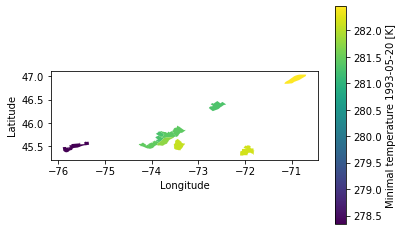

In [29]:
# Now we can plot easily the results as a choropleth map!
ax = shapes_data.plot('tasmin', legend=True, legend_kwds={'label': 'Minimal temperature 1993-05-20 [K]'})
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')